#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2944450417581025485
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6014790937724249600
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [6]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [7]:
data = pd.read_csv("data/data_kw.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [8]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [9]:
As = data
Cd = data
Ni = data

In [10]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [11]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(677, 16)
(677, 16)
(677, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [12]:
import smogn

In [13]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

r_index: 100%|##########| 38/38 [00:00<00:00, 643.92it/s]


In [14]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(971, 16)
(887, 16)
(986, 16)


#### Eliminate outlier and train / test split

In [15]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [16]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [17]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [18]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [19]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(787, 15)
(751, 15)
(978, 15)


StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

MinMaxScaler

In [11]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [21]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(629, 15)
(600, 15)
(782, 15)


#### 10-Fold Crossvalidation

In [22]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [23]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [24]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [25]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 13:50:37,836] A new study created in memory with name: rf_parameter_opt
[I 2023-08-15 13:50:38,396] Trial 0 finished with value: 0.39453089099850064 and parameters: {'n_estimators': 74, 'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 11}. Best is trial 0 with value: 0.39453089099850064.
[I 2023-08-15 13:50:38,729] Trial 1 finished with value: 0.338476266251869 and parameters: {'n_estimators': 49, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4}. Best is trial 0 with value: 0.39453089099850064.
[I 2023-08-15 13:50:39,347] Trial 2 finished with value: 0.4000758906695232 and parameters: {'n_estimators': 84, 'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 6}. Best is trial 2 with value: 0.4000758906695232.
[I 2023-08-15 13:50:39,708] Trial 3 finished with value: 0.09048145152390792 and parameters: {'n_estimators': 67, 'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 19}. Best is trial 2 with value: 0.4000758906695232.
[I 2023

Best r2:  0.5405012954227083
Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [26]:
optuna.visualization.plot_parallel_coordinate(study)

In [27]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [28]:
study.best_trial.params["n_estimators"]

97

In [29]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, n_estimators=97, random_state=42)

In [30]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [22]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [31]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.2659400550249024
Test RMSE:  0.656150387541336


In [32]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9119633097572404
Test R2:  0.47717743359873044


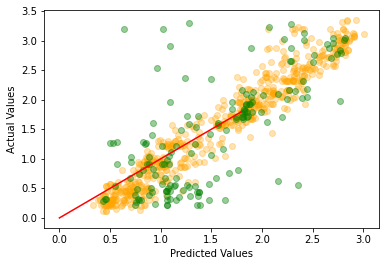

In [33]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [34]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 14:06:01,438] A new study created in memory with name: rf_parameter_opt
[I 2023-08-15 14:06:01,780] Trial 0 finished with value: 0.16726773523931232 and parameters: {'n_estimators': 58, 'max_depth': 1, 'min_samples_leaf': 14, 'min_samples_split': 14}. Best is trial 0 with value: 0.16726773523931232.
[I 2023-08-15 14:06:02,037] Trial 1 finished with value: 0.4698007049490756 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 5}. Best is trial 1 with value: 0.4698007049490756.
[I 2023-08-15 14:06:02,441] Trial 2 finished with value: 0.4794147590191371 and parameters: {'n_estimators': 55, 'max_depth': 9, 'min_samples_leaf': 18, 'min_samples_split': 10}. Best is trial 2 with value: 0.4794147590191371.
[I 2023-08-15 14:06:02,996] Trial 3 finished with value: 0.5006472549839549 and parameters: {'n_estimators': 72, 'max_depth': 9, 'min_samples_leaf': 12, 'min_samples_split': 3}. Best is trial 3 with value: 0.5006472549839549.
[I 202

Best r2:  0.5670344425279689
Best trial: {'n_estimators': 86, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [35]:
optuna.visualization.plot_parallel_coordinate(study)

In [36]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 86, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


86

In [37]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=86,
                      random_state=42)

In [38]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [39]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.09609000302671444
Test RMSE:  0.17458474919942302


In [40]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.8950877683539488
Test R2:  0.6503889670572968


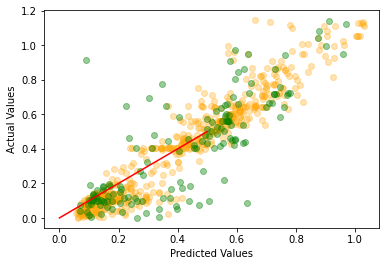

In [41]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [42]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 14:19:06,426] A new study created in memory with name: rf_parameter_opt
[I 2023-08-15 14:19:06,696] Trial 0 finished with value: 0.5868854361849583 and parameters: {'n_estimators': 29, 'max_depth': 6, 'min_samples_leaf': 11, 'min_samples_split': 19}. Best is trial 0 with value: 0.5868854361849583.
[I 2023-08-15 14:19:07,326] Trial 1 finished with value: 0.30125484742176234 and parameters: {'n_estimators': 92, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.5868854361849583.
[I 2023-08-15 14:19:07,709] Trial 2 finished with value: 0.602566939494804 and parameters: {'n_estimators': 42, 'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 15}. Best is trial 2 with value: 0.602566939494804.
[I 2023-08-15 14:19:08,555] Trial 3 finished with value: 0.5722078866902607 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}. Best is trial 2 with value: 0.602566939494804.
[I 2023

Best r2:  0.703734685450793
Best trial: {'n_estimators': 64, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [43]:
optuna.visualization.plot_parallel_coordinate(study)

In [44]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 64, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


64

In [45]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, n_estimators=64, random_state=42)

In [46]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [47]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.31981130655394746
Test RMSE:  0.638721455842329


In [48]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9284430394918757
Test R2:  0.7091510927493629


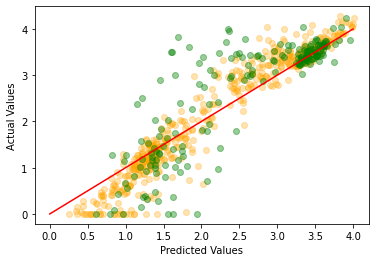

In [49]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()